# Semantic Segmentation with DeepLabV3

In this notebook we train a semantic segmentation using ear dataset [1], we use the DeepLabV3 model with ResNet50 backbone and train the model to classifiy pixels into two classes (background and ear). 

**References**

[1] http://zverina.fri.uni-lj.si:9000/web/ibb-joint-data.zip.

[2] https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/

[3] https://towardsdatascience.com/transfer-learning-for-segmentation-using-deeplabv3-in-pytorch-f770863d6a42

## Setup

Import dependencies, mount google drive and unzip data.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from skimage import io, transform
import PIL
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms, utils
from tqdm import tqdm

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

#FOLDERNAME = "IBB5"
#assert FOLDERNAME is not None, "[!] Enter the foldername."

#import sys
#DATA_PATH = '/content/drive/My Drive/{}'.format(FOLDERNAME)
#print(DATA_PATH)
#sys.path.append(DATA_PATH)

#ROOT_PATH = "."

In [3]:
#!unzip "/content/drive/My Drive/IBB5/data.zip" 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

ROOT_PATH = "/kaggle/input/eardataset/"

### Split data into train and test set

Annotation dataframe has the following columns: Subject ID, Image name without ending, Gender, Ethnicity, Left or right

In [5]:
annotations = pd.read_csv(f"{ROOT_PATH}/annotations.csv", delimiter="\t", dtype="str")
annotations.head(5)

,CID,Image,Gender,Ethnicity,LR
0,001,01,m,1,r
1,001,02,m,1,l
2,001,03,m,1,l
3,001,04,m,1,l
4,001,05,m,1,l


In [6]:
print(annotations.columns)
print(annotations.shape)

Index(['CID', 'Image', 'Gender', 'Ethnicity', 'LR'], dtype='object')
(14276, 5)


In [7]:
import math
np.random.seed(1235)

annotations_train, annotations_test = [], []

for idx, (name, group) in enumerate(annotations.groupby("CID")):
    # Reset the group indices
    group = group.reset_index(drop=True)
    n_images = len(group)
    n_samples = math.floor(0.8 * n_images) if n_images > 1 else 1

    train_idxs = np.random.choice(n_images, n_samples, replace=False)
    test_idxs = np.setdiff1d(np.arange(0, n_images), train_idxs)

    train_rows = np.array(group.loc[train_idxs])
    test_rows = np.array(group.loc[test_idxs])

    if len(train_rows):
        annotations_train.extend(train_rows)

    if len(test_rows):
        annotations_test.extend(test_rows)


annotations_train = pd.DataFrame(annotations_train, columns=annotations.columns)
annotations_test = pd.DataFrame(annotations_test, columns=annotations.columns)
print(annotations_train.shape, annotations_test.shape)

(11221, 5) (3055, 5)


In [8]:
annotations_train[annotations_train["CID"] == "005"]

,CID,Image,Gender,Ethnicity,LR
82,005,03,m,1,l


In [9]:
annotations_test[annotations_test["CID"] == "005"]

,CID,Image,Gender,Ethnicity,LR
22,005,02,m,1,l


In [10]:
annotations_train.to_csv(f"./annotations_train.csv", sep="\t", index=False)
annotations_test.to_csv(f"./annotations_test.csv", sep="\t", index=False)

## Visualize data



In [11]:
class EarDataset(Dataset):
    def __init__(
        self, annotations_file, image_dir="./images", mask_dir="./masks", transform=None
    ):
        super().__init__()
        self.annotations = pd.read_csv(annotations_file, delimiter="\t", dtype="str")
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Fetch image and mask name
        folder_name, file_name = np.array(self.annotations.iloc[idx, :2])
        image_name = os.path.join(self.image_dir, f"{folder_name}/{file_name}.png")
        mask_name = os.path.join(self.mask_dir, f"{folder_name}/{file_name}.png")

        # Read image and mask & convert to numpy array
        image = np.array(PIL.Image.open(image_name))
        mask = np.array(PIL.Image.open(mask_name).convert("L"))
        mask = mask[:, :, np.newaxis]
        mask[mask == 255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=image, mask=mask)
            image, mask = augmentation["image"], augmentation["mask"] 

        return image, mask

class ToTensor(object):
    def __call__(self, sample):
        image, mask = sample

        # Swap color axis because:
        # numpy image: H x W x C
        # torch image: C x H x W
        image = image.transpose((2, 0, 1))
        image = torch.from_numpy(image)
        mask = torch.from_numpy(mask[np.newaxis, :, :])

        return image, mask

In [12]:
train_dataset = EarDataset(annotations_file="./annotations_train.csv",
                        image_dir=f"{ROOT_PATH}/images",
                        mask_dir=f"{ROOT_PATH}/masks")

print(len(train_dataset))

11221


In [13]:
def plot_sample(image, mask):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    mask = mask.squeeze() if mask.ndim == 3 else mask
    plt.imshow(mask, alpha=0.6 * (mask > 0))
    plt.show()

(449, 366, 3) (449, 366, 1)
uint8 uint8


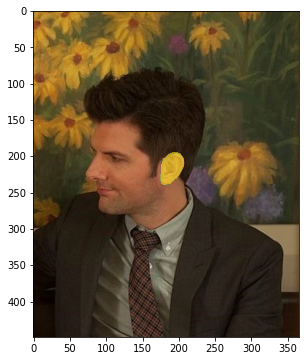

(453, 229, 3) (453, 229, 1)
uint8 uint8


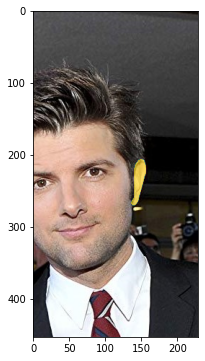

(419, 533, 3) (419, 533, 1)
uint8 uint8


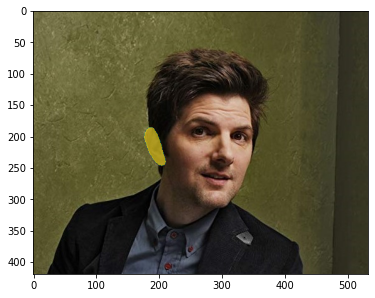

In [14]:
for idx in range(3):
    image, mask = train_dataset[idx]
    print(image.shape, mask.shape)
    print(image.dtype, mask.dtype)
    plot_sample(image, mask)

### Data Transforms

In [15]:
from albumentations.pytorch import ToTensorV2
import albumentations

IMAGE_HEIGHT, IMAGE_WIDTH = 300, 300
preprocess_transform = albumentations.Compose([
    albumentations.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    albumentations.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0], max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True)
])

train_dataset = EarDataset(annotations_file="./annotations_train.csv",
                    image_dir=f"{ROOT_PATH}/images",
                    mask_dir=f"{ROOT_PATH}/masks",
                    transform=preprocess_transform)

print(f"len(train_dataset): {len(train_dataset)}")

len(train_dataset): 11221


In [16]:
dataloader = DataLoader(train_dataset,
                        batch_size=8,
                        shuffle=True,
                        num_workers=0)

for batch_idx, sample_batch in enumerate(dataloader):
    images, masks = sample_batch
    print(images.shape, masks.shape)
    print(images.dtype, masks.float().dtype)
    break

torch.Size([8, 3, 300, 300]) torch.Size([8, 1, 300, 300])
torch.float32 torch.float32


## DeepLabV3 Model


### Load & Setup original DeepLabV3 model

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape `(N, 3, H, W)`, where `N` is the number of images, `H` and `W` are expected to be at least 224 pixels. The images have to be loaded in to a range of `[0, 1]` and then normalized using `mean = [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`.

The model returns an `OrderedDict` with two Tensors that are of the same height and width as the input Tensor, but with 21 classes. `output['out']` contains the semantic masks, and `output['aux']` contains the auxiliary loss values per-pixel. In inference mode, `output['aux']` is not useful. So, `output['out']` is of shape `(N, 21, H, W)`.

The `output['out']` is of shape `(21, H, W)`. At each location there are unnormalized probabilities corresponding to the prediction of each class.

In [17]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [18]:
import torchvision
model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


  0%|          | 0.00/161M [00:00<?, ?B/s]

In [19]:
image, mask = train_dataset[0]
image_batch = image.unsqueeze(dim=0)
mask_batch = mask.unsqueeze(dim=0)

if torch.cuda.is_available():
    print("Moving model and data to cuda")
    image_batch = image_batch.to("cuda")
    model = model.to("cuda")

with torch.no_grad():
    model.eval()
    out = model(image_batch)["out"][0]
    print(out.shape)

out_pred = out.argmax(dim=0)
out_pred.shape

Moving model and data to cuda
torch.Size([21, 300, 300])


torch.Size([300, 300])

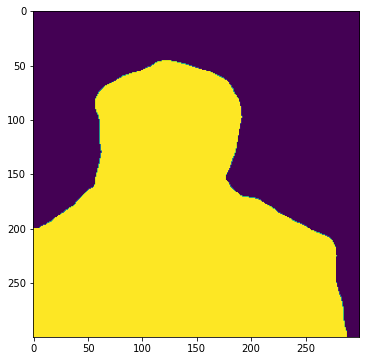

In [20]:
plt.figure(figsize=(6, 6))
plt.imshow(out_pred.cpu())

### Custom DeepLabV3 Model

We'll swap the number of output channels from 21 to 1, since we are dealing with only one class, i.e the ear class.

In [21]:
from torchvision.models.segmentation.deeplabv3 import DeepLabHead
import torchvision

def get_model(out_channels=1, train_mode=False, pretrained=True):
    """
    DeepLabv3 class with a custom head.
    """
    # Load the pretrained model
    model = torchvision.models.segmentation.deeplabv3_resnet50(pretrained=pretrained)

    # Replace the classifier module with a new head
    model.classifier = DeepLabHead(2048, out_channels)

    # Set model in appropriate mode
    model.train() if train_mode else model.eval()

    return model

In [22]:
model = get_model(out_channels=1, train_mode=False)

In [23]:
image, mask = train_dataset[0]
image_batch = image.unsqueeze(dim=0)
mask_batch = mask.unsqueeze(dim=0)

if torch.cuda.is_available():
    print("Moving model and data to cuda")
    image_batch = image_batch.to("cuda")
    model = model.to("cuda")

with torch.no_grad():
    out = model(image_batch)["out"][0]
    print(out.shape)
    
out_pred = torch.sigmoid(out)

Moving model and data to cuda
torch.Size([1, 300, 300])


## Training

https://www.youtube.com/watch?v=hWN1Xqu8aRE&ab_channel=TalhaAnwar

### Overfit a single batch of data

In [24]:
LEARNING_RATE = 0.5e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 100
NUM_WORKERS = 0 # 2
IMAGE_HEIGHT = 300 
IMAGE_WIDTH = 300 
PIN_MEMORY = True
LOAD_MODEL = False

In [25]:
from albumentations.pytorch import ToTensorV2
import albumentations

preprocess_transform = albumentations.Compose([
    albumentations.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    albumentations.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True)
])

train_dataset = EarDataset(annotations_file="./annotations_train.csv",
                    image_dir=f"{ROOT_PATH}/images",
                    mask_dir=f"{ROOT_PATH}/masks",
                    transform=preprocess_transform)

print(f"len(dataset): {len(train_dataset)}")

dataloader = DataLoader(train_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY)

len(dataset): 11221


In [26]:
images, masks = next(iter(dataloader))
images.shape, masks.shape

(torch.Size([8, 3, 300, 300]), torch.Size([8, 1, 300, 300]))

In [27]:
model = get_model(out_channels=1, train_mode=True)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
losses = []

for epoch in range(NUM_EPOCHS):
    # Move data and model to device
    images = images.to(DEVICE)
    masks = masks.float().to(DEVICE) 
    model = model.to(DEVICE)

    # Forward pass
    # pred_masks are unnormalized probabilities corresponding to each class 
    pred_masks = model(images)["out"]
    # pred_masks are now between 0 and 1 (Prob. of each pixel being an object)
    pred_masks = torch.sigmoid(pred_masks)

    #print(pred_masks.shape, masks.shape)
    #print(pred_masks.dtype, masks.dtype)

    # Backward pass
    loss = loss_fn(pred_masks, masks)
    optimizer.zero_grad()
    loss.backward()

    # Update model parameters
    optimizer.step()
    print(f"epoch: {epoch} \t loss: {loss.item()}")
    losses.append(loss.item())

epoch: 0 	 loss: 0.6309024095535278
epoch: 1 	 loss: 0.6278123259544373
epoch: 2 	 loss: 0.646014392375946
epoch: 3 	 loss: 0.560520589351654
epoch: 4 	 loss: 0.49391797184944153
epoch: 5 	 loss: 0.42641544342041016
epoch: 6 	 loss: 0.3769012689590454
epoch: 7 	 loss: 0.3382861614227295
epoch: 8 	 loss: 0.3008783757686615
epoch: 9 	 loss: 0.26995107531547546
epoch: 10 	 loss: 0.24747343361377716
epoch: 11 	 loss: 0.22784605622291565
epoch: 12 	 loss: 0.21030087769031525
epoch: 13 	 loss: 0.19623275101184845
epoch: 14 	 loss: 0.18324397504329681
epoch: 15 	 loss: 0.17116469144821167
epoch: 16 	 loss: 0.16210760176181793
epoch: 17 	 loss: 0.15313291549682617
epoch: 18 	 loss: 0.14419065415859222
epoch: 19 	 loss: 0.13851194083690643
epoch: 20 	 loss: 0.13206684589385986
epoch: 21 	 loss: 0.12529820203781128
epoch: 22 	 loss: 0.12071926891803741
epoch: 23 	 loss: 0.11614592373371124
epoch: 24 	 loss: 0.1110791489481926
epoch: 25 	 loss: 0.10670411586761475
epoch: 26 	 loss: 0.103559911251

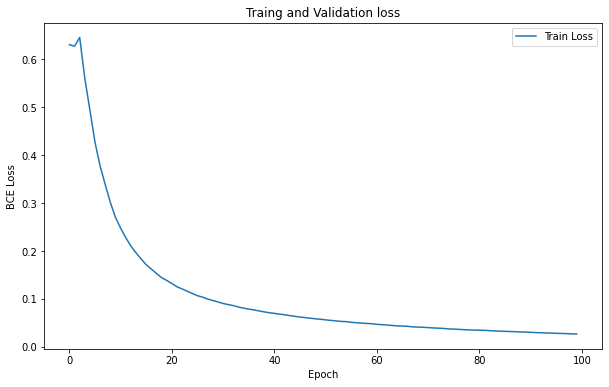

In [28]:
plt.figure(figsize=(10,6))
plt.plot(losses, label="Train Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Traing and Validation loss")
plt.legend()

In [29]:
def plot_predictions(images, masks, pred_masks, n_samples=3):
    images = images.to("cpu").detach()
    masks = masks.to("cpu").detach()
    pred_masks = pred_masks.to("cpu").detach()

    for idx, (image, mask, pred_mask) in enumerate(zip(images, masks, pred_masks)):
        if idx == n_samples:
            break

        if torch.is_tensor(image):
            image = image.numpy()
            image = image.transpose((1, 2, 0))

        if torch.is_tensor(mask):
            mask = mask.numpy()
            mask = mask.squeeze(axis=0)

        if torch.is_tensor(pred_mask):
            pred_mask = pred_mask.numpy()
            pred_mask = pred_mask.squeeze(axis=0)

        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        # plt.imshow(mask, alpha=0.6 * (mask > 0))
        plt.imshow(pred_mask, alpha=0.6 * (mask > 0))
        plt.show()
        
        
def de_normalize(images, mean, std):
    if isinstance(mean, list):
        mean = torch.tensor(mean).reshape((3, 1, 1)).to(DEVICE)
        
    if isinstance(std, list):
        std = torch.tensor(std).reshape((3, 1, 1)).to(DEVICE)
    
    images = (images + mean) * std
    
    return images

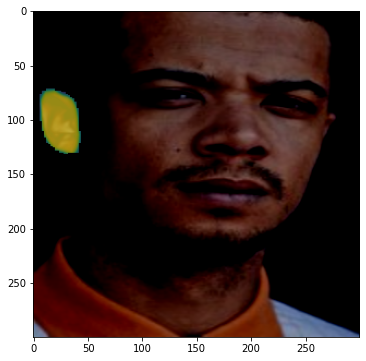

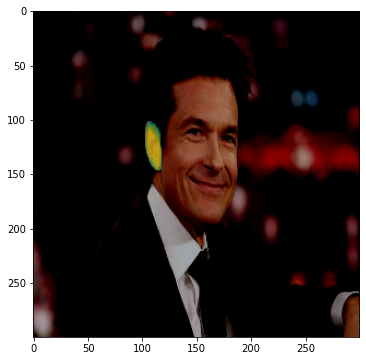

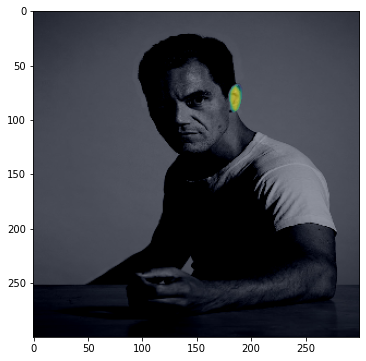

In [30]:
plot_predictions(de_normalize(images, mean, std), masks, pred_masks, n_samples=3)

### Train the entire network

In [31]:
LEARNING_RATE = 0.5e-3
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 32
NUM_EPOCHS = 10
PRINT_PERIOD = 1
NUM_WORKERS = 2
IMAGE_HEIGHT = 300 
IMAGE_WIDTH = 300  
PIN_MEMORY = True
LOAD_MODEL = False
MODELS_DIR = "./DeepLabV3_v1"

In [32]:
#model = get_model(out_channels=1, train_mode=True)
#torch.save(model.state_dict(), MODELS_DIR)

#model = get_model(out_channels=1, train_mode=False, pretrained=True)
#model.load_state_dict(torch.load(MODELS_DIR))

**Split into train and validation set**

In [33]:
from albumentations.pytorch import ToTensorV2
import albumentations

preprocess_transform = albumentations.Compose([
    albumentations.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    albumentations.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True)
])

dataset = EarDataset(annotations_file="./annotations_train.csv",
                    image_dir=f"{ROOT_PATH}/images",
                    mask_dir=f"{ROOT_PATH}/masks",
                    transform=preprocess_transform)


n_train = int(0.8 * len(dataset))
train_loader = DataLoader(Subset(dataset, range(n_train)),
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

val_loader = DataLoader(Subset(dataset, range(n_train, len(dataset))),
                            batch_size=BATCH_SIZE,
                            shuffle=True,
                            num_workers=NUM_WORKERS,
                            pin_memory=PIN_MEMORY)

In [34]:
import time
start_time = time.time()

for batch_idx, sample_batched in enumerate(train_loader):
    image, landmarks = sample_batched
    print(batch_idx, image.size(), landmarks.size())
    
    break

print("--- %s seconds ---" % (time.time() - start_time))

0 torch.Size([32, 3, 300, 300]) torch.Size([32, 1, 300, 300])
--- 5.0764830112457275 seconds ---


**Training loop**

Each epoch takes around (11 minutes for training, 6 minutes for evaliation). 25 epochs should take around 9 hours.

In [35]:
import time
from tqdm import tqdm

model = get_model(out_channels=1, train_mode=True)
loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [36]:
losses_train, losses_val = [], []
best_val_loss = None

for epoch in tqdm(range(NUM_EPOCHS)):
    start_time = time.time()

    # Iterate over batches of data

    for batch_idx, sample_batch in enumerate(train_loader):            
        images, masks = sample_batch

        # Move data and model to device
        images = images.to(DEVICE)
        masks = masks.float().to(DEVICE) 
        model = model.to(DEVICE)

        # Forward pass
        # pred_masks are 0.0 <= Prob(object) <= 1.0
        pred_masks = torch.sigmoid(model(images)["out"])

        # Backward pass
        loss = loss_fn(pred_masks, masks)
        optimizer.zero_grad()
        loss.backward()

        # Update model parameters
        optimizer.step()

    train_time = time.time() - start_time

    # Evaluate model performance
    start_time = time.time()

    with torch.no_grad():
        #Evaluate on the whole training set
        train_loss = 0
        for n, (images, masks) in enumerate(train_loader):
            images = images.to(DEVICE)
            masks = masks.float().to(DEVICE) 
            model = model.to(DEVICE)

            pred_masks = torch.sigmoid(model(images)["out"])
            loss = loss_fn(pred_masks, masks)
            train_loss += loss.item()
        
        train_loss = train_loss / (n + 1)
        
        # Evaluate on the whole validation set
        val_loss = 0
        for n, (images, masks) in enumerate(val_loader):
            images = images.to(DEVICE)
            masks = masks.float().to(DEVICE) 
            model = model.to(DEVICE)

            pred_masks = torch.sigmoid(model(images)["out"])
            loss = loss_fn(pred_masks, masks)

            val_loss += loss.item()

        val_loss = val_loss / (n + 1)

    losses_train.append(train_loss)
    losses_val.append(val_loss)

    eval_time = time.time() - start_time

    if epoch % PRINT_PERIOD == 0:
        print(f"epoch: {epoch} \t train_time: {train_time} \t eval_time: {eval_time:.4f} \t train_loss: {loss:.4f} \t val_loss: {val_loss:.4f}")
        
      # Check if current model is the best so far and save it
    if best_val_loss is None or val_loss < best_val_loss:
        print(f"Saving model: {MODELS_DIR}")
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODELS_DIR)

  0%|          | 0/10 [00:00<?, ?it/s]

epoch: 0 	 train_time: 540.9508125782013 	 eval_time: 321.0652 	 train_loss: 0.0093 	 val_loss: 0.0096
Saving model: ./DeepLabV3_v1


 10%|█         | 1/10 [14:22<2:09:22, 862.45s/it]

epoch: 1 	 train_time: 540.3263955116272 	 eval_time: 310.6440 	 train_loss: 0.0066 	 val_loss: 0.0055
Saving model: ./DeepLabV3_v1


 20%|██        | 2/10 [28:33<1:54:07, 855.97s/it]

epoch: 2 	 train_time: 539.9047672748566 	 eval_time: 307.0510 	 train_loss: 0.0046 	 val_loss: 0.0040
Saving model: ./DeepLabV3_v1


 40%|████      | 4/10 [56:51<1:25:07, 851.33s/it]

epoch: 3 	 train_time: 539.4322369098663 	 eval_time: 310.7499 	 train_loss: 0.0057 	 val_loss: 0.0042
epoch: 4 	 train_time: 539.3948674201965 	 eval_time: 302.4535 	 train_loss: 0.0037 	 val_loss: 0.0039
Saving model: ./DeepLabV3_v1


 50%|█████     | 5/10 [1:10:53<1:10:40, 848.11s/it]

epoch: 5 	 train_time: 539.7594108581543 	 eval_time: 301.2857 	 train_loss: 0.0028 	 val_loss: 0.0033
Saving model: ./DeepLabV3_v1


 70%|███████   | 7/10 [1:38:58<42:15, 845.00s/it]

epoch: 6 	 train_time: 539.8438317775726 	 eval_time: 303.2898 	 train_loss: 0.0029 	 val_loss: 0.0048


 80%|████████  | 8/10 [1:52:51<28:02, 841.10s/it]

epoch: 7 	 train_time: 538.9853842258453 	 eval_time: 293.7557 	 train_loss: 0.0043 	 val_loss: 0.0044


 90%|█████████ | 9/10 [2:06:51<14:00, 840.71s/it]

epoch: 8 	 train_time: 539.5628571510315 	 eval_time: 300.2819 	 train_loss: 0.0030 	 val_loss: 0.0040
epoch: 9 	 train_time: 539.1321303844452 	 eval_time: 307.3859 	 train_loss: 0.0034 	 val_loss: 0.0031
Saving model: ./DeepLabV3_v1


100%|██████████| 10/10 [2:20:58<00:00, 845.83s/it]


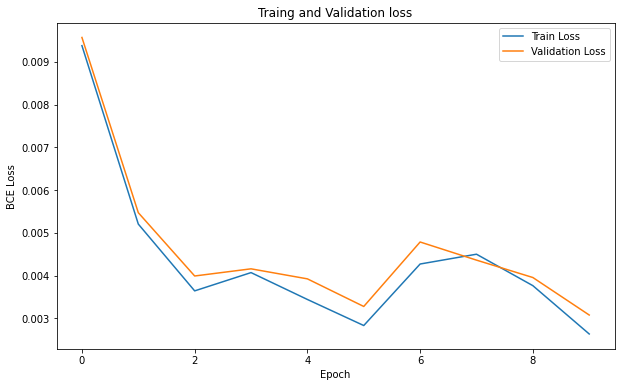

In [37]:
plt.figure(figsize=(10,6))
plt.plot(losses_train, label="Train Loss")
plt.plot(losses_val, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("BCE Loss")
plt.title("Traing and Validation loss")
plt.legend()

**Plot validation set predtictions**

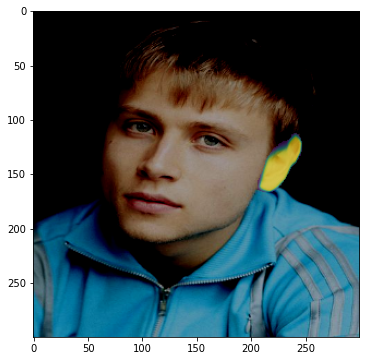

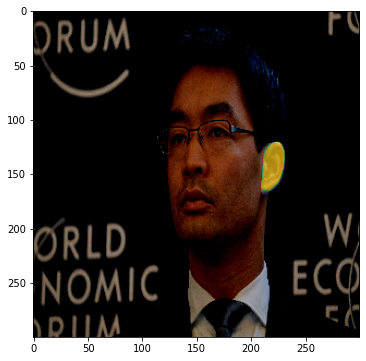

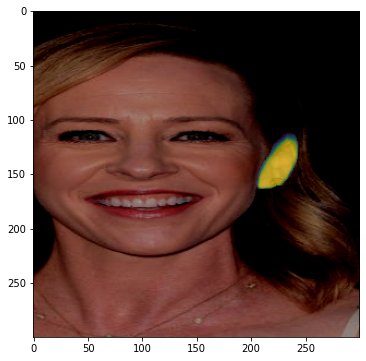

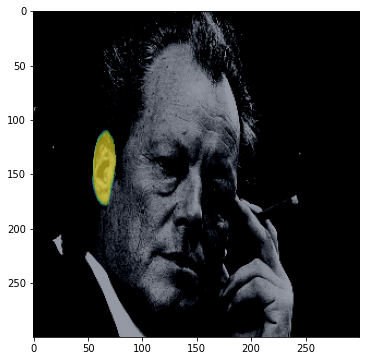

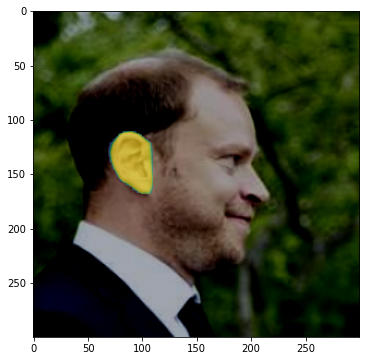

In [38]:
plot_predictions(de_normalize(images, mean, std), masks, pred_masks, n_samples=10)

## Evaluation

In [39]:
# Clear CUDA Memory
del train_loader
del val_loader
del model

import gc
gc.collect()
torch.cuda.empty_cache()

**Load test dataset and trained model**

In [40]:
model = get_model(out_channels=1, train_mode=False, pretrained=True)
model.load_state_dict(torch.load(MODELS_DIR))

<All keys matched successfully>

In [41]:
from albumentations.pytorch import ToTensorV2
import albumentations

preprocess_transform = albumentations.Compose([
    albumentations.Resize(width=IMAGE_WIDTH, height=IMAGE_HEIGHT),
    albumentations.Normalize(mean=mean, std=std, max_pixel_value=255.0),
    ToTensorV2(transpose_mask=True)
])

test_dataset = EarDataset(annotations_file="./annotations_test.csv",
                    image_dir=f"{ROOT_PATH}/images",
                    mask_dir=f"{ROOT_PATH}/masks",
                    transform=preprocess_transform)

test_loader = DataLoader(test_dataset,
                        batch_size=BATCH_SIZE,
                        shuffle=True,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY)

In [42]:
images, masks = next(iter(test_loader))
images.shape, masks.shape

(torch.Size([32, 3, 300, 300]), torch.Size([32, 1, 300, 300]))

**BCE Loss on the Test set**

In [43]:
from tqdm import tqdm

test_loss = 0
with torch.no_grad():
    for n, (images, masks) in enumerate(tqdm(test_loader)):
        images = images.to(DEVICE)
        masks = masks.float().to(DEVICE) 
        model = model.to(DEVICE)

        pred_masks = torch.sigmoid(model(images)["out"])
        loss = loss_fn(pred_masks, masks)

        test_loss += loss.item()

    test_loss = test_loss / (n + 1)

print(f"test_loss: {test_loss}")

100%|██████████| 96/96 [01:36<00:00,  1.00s/it]

test_loss: 0.0029077451605796036


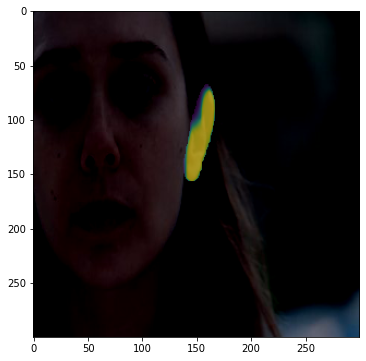

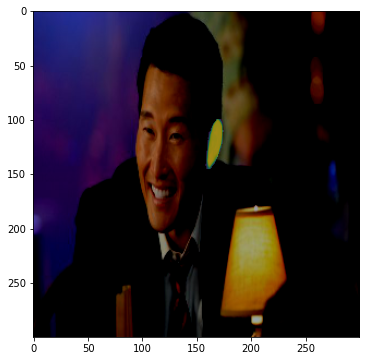

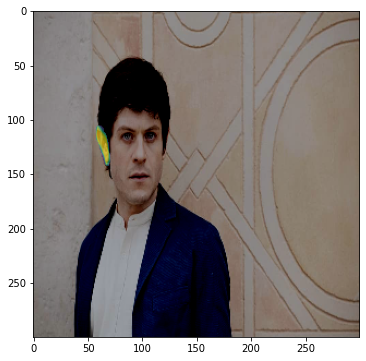

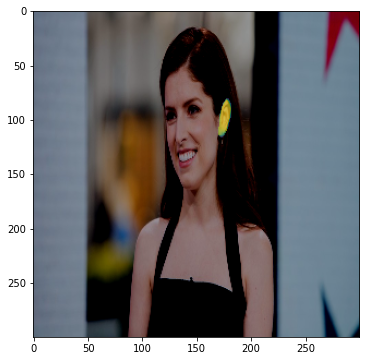

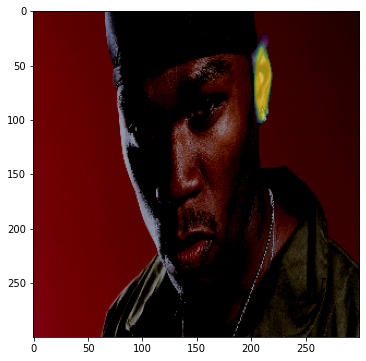

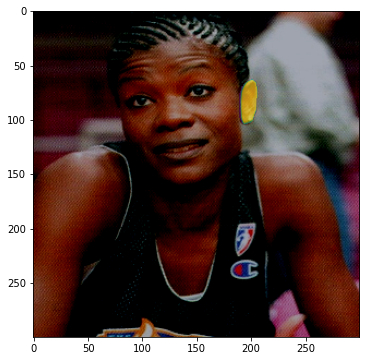

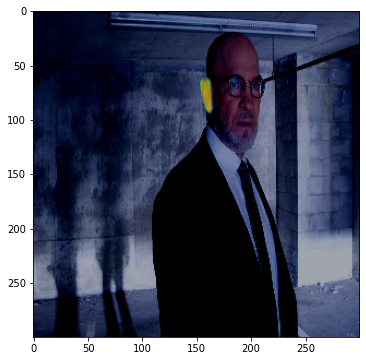

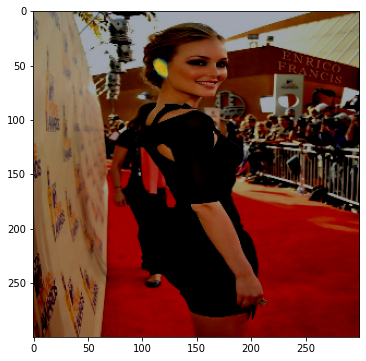

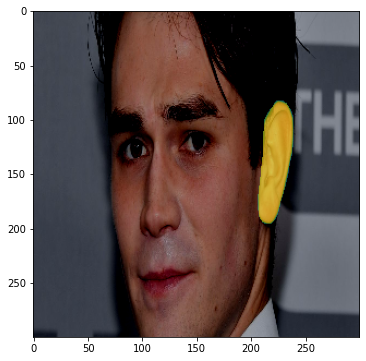

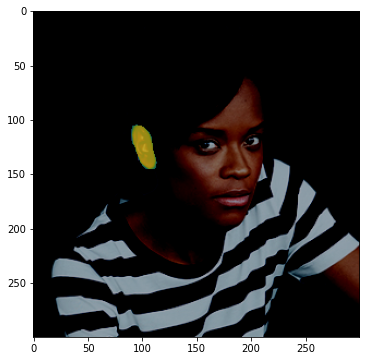

In [44]:
plot_predictions(de_normalize(images, mean, std), masks, pred_masks, n_samples=10)

**Mean Intersection Over Union**

In [45]:
from torchmetrics import JaccardIndex

# In the JaccardIndex class, the threshold parameter specifies the threshold 
# at which the predicted values are considered to be "positive".
# num_classes=2, this means that there are two classes in the data, and the 
# JaccardIndex class will expect the predictions and labels to have binary values (i.e. 0 or 1).
jaccard = JaccardIndex(num_classes=2, threshold=0.5)


ious_dict = {} # <image idx : iou>
with torch.no_grad():
    for idx, (image, mask) in enumerate(tqdm(test_dataset)):
        image = image.unsqueeze(dim=0).to(DEVICE)
        mask = mask.unsqueeze(dim=0).to(DEVICE)
        
        model = model.to(DEVICE)
        pred_mask = torch.sigmoid(model(image)["out"])
        
        iou = jaccard(pred_mask.to("cpu"), mask.int().to("cpu"))
        ious_dict[idx] = iou.item() 

100%|██████████| 3055/3055 [03:33<00:00, 14.32it/s]


In [46]:
sorted_ious = {k: v for k, v in sorted(ious_dict.items(), key=lambda item: item[1], reverse=True)}
best_idxs = list(sorted_ious.keys())[0:3]
worst_idxs = list(sorted_ious.keys())[-3:]

**Visualize best and worst predictions**

iou: 0.98700350522995


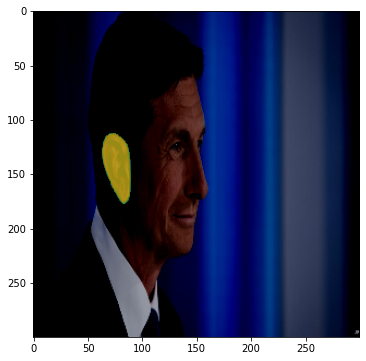

iou: 0.986283540725708


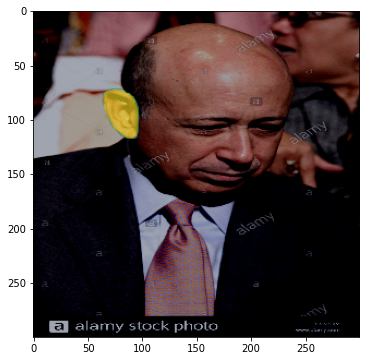

iou: 0.9858615398406982


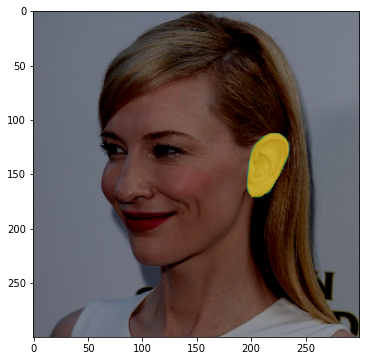

In [47]:
for idx in best_idxs:
    image, mask = test_dataset[idx]
    image = image.unsqueeze(dim=0).to(DEVICE)
    mask = mask.unsqueeze(dim=0).to(DEVICE)
    model = model.to(DEVICE)
    
    pred_mask = torch.sigmoid(model(image)["out"])
    
    print(f"iou: {ious_dict[idx]}")
    plot_predictions(de_normalize(image, mean, std), mask, pred_mask, n_samples=1)

iou: 0.49738332629203796


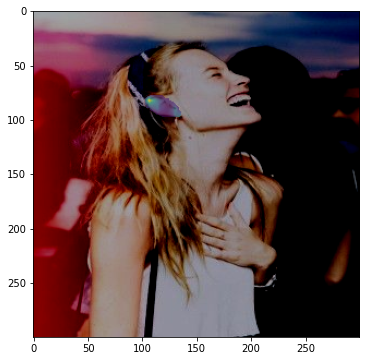

iou: 0.4962666630744934


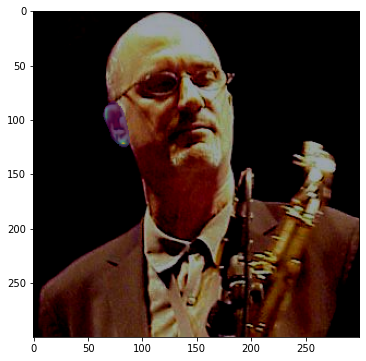

iou: 0.4886888861656189


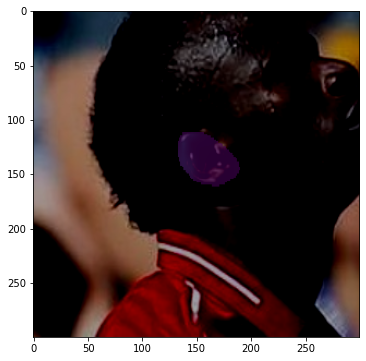

In [48]:
for idx in worst_idxs:
    image, mask = test_dataset[idx]
    image = image.unsqueeze(dim=0).to(DEVICE)
    mask = mask.unsqueeze(dim=0).to(DEVICE)
    model = model.to(DEVICE)
    
    pred_mask = torch.sigmoid(model(image)["out"])
    
    print(f"iou: {ious_dict[idx]}")
    plot_predictions(de_normalize(image, mean, std), mask, pred_mask, n_samples=1)

Text(0.5, 1.0, 'Distribution of IoUs over test samples')

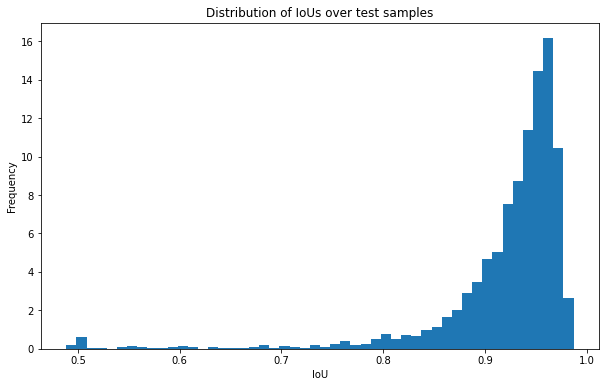

In [49]:
ious = np.array(list(sorted_ious.values())) 

plt.figure(figsize=(10, 6))
plt.hist(ious, bins=50, density=True)
plt.xlabel("IoU")
plt.ylabel("Frequency")
plt.title("Distribution of IoUs over test samples")